In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,  LogisticRegression, Lasso, RidgeCV, BayesianRidge
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import GroupKFold

#from src.svm_model import svm_log_prob, svm_optim_step, svm_sample_missing

plt.style.use("fivethirtyeight")
mypal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
data_path = "/content/"

In [6]:
df_seeds = pd.concat(
    [
        pd.read_csv(data_path + "MNCAATourneySeeds.csv").assign(League="M"),
        pd.read_csv(data_path + "WNCAATourneySeeds.csv").assign(League="W"),
    ],
).reset_index(drop=True)

df_season_results = pd.concat(
    [
        pd.read_csv(data_path + "MRegularSeasonDetailedResults.csv").assign(League="M"),
        pd.read_csv(data_path + "WRegularSeasonDetailedResults.csv").assign(League="W"),
    ]
).reset_index(drop=True)

df_tourney_results = pd.concat(
    [
        pd.read_csv(data_path + "MNCAATourneyCompactResults.csv").assign(League="M"),
        pd.read_csv(data_path + "WNCAATourneyCompactResults.csv").assign(League="W"),
    ]
).reset_index(drop=True)

fivethiryeight_scores = pd.concat(
    [
        pd.read_csv(data_path + "538ratingsMen.csv").assign(League="M"),
        pd.read_csv(data_path + "538ratingsWomen.csv").assign(League="W"),
    ]
).reset_index(drop=True)

In [7]:
df_team_season_results = pd.concat(
    [
        df_season_results[["Season", "League", "WTeamID", "DayNum", "WScore", "LScore",
                           "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR",
                           "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]
        .assign(GameResult="W")
        .rename(
            columns={"WTeamID": "TeamID", "WScore": "TeamScore", "LScore": "OppScore",
                     "WFGM": "FieldGoalsMade", "WFGA": "FieldGoalsAtp",
                     "WFGM3": "ThreePointersMade", "WFGA3": "ThreePointersAtp",
                     "WFTM": "FreeThrowsMade", "WFTA": "FreeThrowsAtp",
                     "WOR": "OffensiveRebound", "WDR": "DefensiveRebound",
                     "WAst": "Assists", "WTO": "Turnovers", "WStl": "Steals",
                     "WBlk": "Blocks", "WPF": "PersonalFouls"}
        ),
        df_season_results[["Season", "League", "LTeamID", "DayNum", "WScore", "LScore",
                           "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR",
                           "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF"]]
        .assign(GameResult="L")
        .rename(
            columns={"LTeamID": "TeamID", "LScore": "TeamScore", "WScore": "OppScore",
                     "LFGM": "FieldGoalsMade", "LFGA": "FieldGoalsAtp",
                     "LFGM3": "ThreePointersMade", "LFGA3": "ThreePointersAtp",
                     "LFTM": "FreeThrowsMade", "LFTA": "FreeThrowsAtp",
                     "LOR": "OffensiveRebound", "LDR": "DefensiveRebound",
                     "LAst": "Assists", "LTO": "Turnovers", "LStl": "Steals",
                     "LBlk": "Blocks", "LPF": "PersonalFouls"}
        ),
    ]
).reset_index(drop=True)

df_team_season_results["ScoreDiff"] = (
    df_team_season_results["TeamScore"] - df_team_season_results["OppScore"]
)
df_team_season_results["Win"] = (df_team_season_results["GameResult"] == "W").astype(
    "int"
)
df_team_season_results["ThreePointerHitRate"] = (
    df_team_season_results["ThreePointersMade"] / df_team_season_results["ThreePointersAtp"]
)
df_team_season_results["FieldGoalsPercentage"] = (
    df_team_season_results["FieldGoalsMade"] / df_team_season_results["FieldGoalsAtp"]
)
df_team_season_results["FreeThrowHitRate"] = (
    df_team_season_results["FreeThrowsMade"] / df_team_season_results["FreeThrowsAtp"]
)

In [8]:
team_season_agg = (
    df_team_season_results.groupby(["Season", "TeamID", "League"])
    .agg(
        AvgScoreDiff=("ScoreDiff", "mean"),
        AvgThreePointerMade=("ThreePointersMade", "mean"),
        AvgThreePointerAtp=("ThreePointersAtp", "mean"),
        AvgFreeThrowsMade= ("FreeThrowsMade", "mean"),
        AvgFreeThrowsAtp=("FreeThrowsAtp", "mean"),
        AvgFieldGoalsMade=("FieldGoalsMade", "mean"),
        AvgFieldGoalsAtp=("FieldGoalsAtp", "mean"),
        AvgThreePointerHitRate=("ThreePointerHitRate", "mean"),
        AvgFieldGoalsPercentage=("FieldGoalsPercentage", "mean"),
        AvgFreeThrowHitRate=("FreeThrowHitRate", "mean"),
        MedianScoreDiff=("ScoreDiff", "median"),
        MinScoreDiff=("ScoreDiff", "min"),
        MaxScoreDiff=("ScoreDiff", "max"),
        Wins=("Win", "sum"),
        Losses=("GameResult", lambda x: (x == "L").sum()),
        WinPercentage=("Win", "mean"),
    )
    .reset_index()
)

In [9]:
df_seeds["SeedNum"] = (
    df_seeds["Seed"].str.replace("a", "").str.replace("b", "").str[1:].astype("int")
)

team_season_agg = team_season_agg.merge(
    df_seeds, on=["Season", "TeamID", "League"], how="left"
)

In [10]:
df_team_tourney_results = pd.concat(
    [
        df_tourney_results[
            ["Season", "League", "WTeamID", "LTeamID", "WScore", "LScore"]
        ]
        .assign(GameResult="W")
        .rename(
            columns={
                "WTeamID": "TeamID",
                "LTeamID": "OppTeamID",
                "WScore": "TeamScore",
                "LScore": "OppScore",
            }
        ),
        df_tourney_results[
            ["Season", "League", "LTeamID", "WTeamID", "LScore", "WScore"]
        ]
        .assign(GameResult="L")
        .rename(
            columns={
                "LTeamID": "TeamID",
                "WTeamID": "OppTeamID",
                "LScore": "TeamScore",
                "WScore": "OppScore",
            }
        ),
    ]
).reset_index(drop=True)

df_team_tourney_results["Win"] = (df_team_tourney_results["GameResult"] == "W").astype(
    "int"
)

In [11]:
df_historic_tourney_features = None

df_historic_tourney_features = df_team_tourney_results.merge(
    team_season_agg[
        ["Season", "League", "TeamID", "AvgScoreDiff", "AvgThreePointerMade",
         "AvgThreePointerAtp", "AvgFreeThrowsMade", "AvgFreeThrowsAtp",
         "AvgFieldGoalsMade", "AvgFieldGoalsAtp", "AvgThreePointerHitRate",
         "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate", "MedianScoreDiff",
         "MinScoreDiff", "WinPercentage", "MaxScoreDiff", "SeedNum"]
    ],
    on=["Season", "League", "TeamID"],
    how="left",
)

df_historic_tourney_features = df_historic_tourney_features.merge(
    team_season_agg[
        ["Season", "League", "TeamID", "AvgScoreDiff", "AvgThreePointerMade",
         "AvgThreePointerAtp", "AvgFreeThrowsMade", "AvgFreeThrowsAtp",
         "AvgFieldGoalsMade", "AvgFieldGoalsAtp", "AvgThreePointerHitRate",
         "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate", "MedianScoreDiff",
         "MinScoreDiff", "WinPercentage", "MaxScoreDiff", "SeedNum"]
    ].rename(
        columns={
            "TeamID": "OppTeamID",
            "WinPercentage": "OppWinPercentage",
            "MedianScoreDiff": "OppMedianScoreDiff",
            "SeedNum": "OppSeedNum",
            "AvgScoreDiff": "OppAvgScoreDiff",
            "AvgThreePointerMade": "OppAvgThreePointerMade",
            "AvgThreePointerAtp": "OppAvgThreePointerAtp",
            "AvgFreeThrowsMade": "OppAvgFreeThrowsMade",
            "AvgFreeThrowsAtp": "OppAvgFreeThrowsAtp",
            "AvgFieldGoalsMade": "OppAvgFieldGoalsMade",
            "AvgFieldGoalsAtp": "OppAvgFieldGoalsAtp",
            "AvgThreePointerHitRate": "OppAvgThreePointerHitRate",
            "AvgFieldGoalsPercentage": "OppAvgFieldGoalsPercentage",
            "AvgFreeThrowHitRate": "OppAvgFreeThrowHitRate",
            "MinScoreDiff": "OppMinScoreDiff",
            "MaxScoreDiff": "OppMaxScoreDiff",
        }
    ),
    on=["Season", "League", "OppTeamID"],
)

In [12]:
df_historic_tourney_features = df_historic_tourney_features.merge(
    fivethiryeight_scores.drop("TeamName", axis=1),
    on=["Season", "League", "TeamID"],
    how="left",
).dropna(subset=["538rating"])

df_historic_tourney_features = df_historic_tourney_features.merge(
    fivethiryeight_scores.drop("TeamName", axis=1).rename(
        columns={"TeamID": "OppTeamID"}
    ),
    on=["Season", "League", "OppTeamID"],
    how="left",
    suffixes=("", "Opp"),
)

df_historic_tourney_features["538ratingDiff"] = (
    df_historic_tourney_features["538rating"]
    - df_historic_tourney_features["538ratingOpp"]
)

In [13]:
df_historic_tourney_features["WinPctDiff"] = (
    df_historic_tourney_features["WinPercentage"]
    - df_historic_tourney_features["OppWinPercentage"]
)

df_historic_tourney_features["SeedNumDiff"] = (
    df_historic_tourney_features["SeedNum"]
    - df_historic_tourney_features["OppSeedNum"]
)

df_historic_tourney_features["AvgScoreDiffDiff"] = (
    df_historic_tourney_features["AvgScoreDiff"]
    - df_historic_tourney_features["OppAvgScoreDiff"]
)

df_historic_tourney_features["MedianScoreDiffDiff"] = (
    df_historic_tourney_features["MedianScoreDiff"]
    - df_historic_tourney_features["OppMedianScoreDiff"]
)

df_historic_tourney_features["AvgThreePointerMadeDiff"] = (
    df_historic_tourney_features["AvgThreePointerMade"]
    - df_historic_tourney_features["OppAvgThreePointerMade"]
)

df_historic_tourney_features["AvgThreePointerAtpDiff"] = (
    df_historic_tourney_features["AvgThreePointerAtp"]
    - df_historic_tourney_features["OppAvgThreePointerAtp"]
)

df_historic_tourney_features["AvgFreeThrowsMadeDiff"] = (
    df_historic_tourney_features["AvgFreeThrowsMade"]
    - df_historic_tourney_features["OppAvgFreeThrowsMade"]
)

df_historic_tourney_features["AvgFreeThrowsAtpDiff"] = (
    df_historic_tourney_features["AvgFreeThrowsAtp"]
    - df_historic_tourney_features["OppAvgFreeThrowsAtp"]
)

df_historic_tourney_features["AvgFieldGoalsMadeDiff"] = (
    df_historic_tourney_features["AvgFieldGoalsMade"]
    - df_historic_tourney_features["OppAvgFieldGoalsMade"]
)

df_historic_tourney_features["AvgFieldGoalsAtpDiff"] = (
    df_historic_tourney_features["AvgFieldGoalsAtp"]
    - df_historic_tourney_features["OppAvgFieldGoalsAtp"]
)

df_historic_tourney_features["AvgThreePointerHitRateDiff"] = (
    df_historic_tourney_features["AvgThreePointerHitRate"]
    - df_historic_tourney_features["OppAvgThreePointerHitRate"]
)

df_historic_tourney_features["AvgFieldGoalsPercentageDiff"] = (
    df_historic_tourney_features["AvgFieldGoalsPercentage"]
    - df_historic_tourney_features["OppAvgFieldGoalsPercentage"]
)

df_historic_tourney_features["AvgFreeThrowHitRateDiff"] = (
    df_historic_tourney_features["AvgFreeThrowHitRate"]
    - df_historic_tourney_features["OppAvgFreeThrowHitRate"]
)

df_historic_tourney_features["MinScoreDiffDiff"] = (
    df_historic_tourney_features["MinScoreDiff"]
    - df_historic_tourney_features["OppMinScoreDiff"]
)

df_historic_tourney_features["MaxScoreDiffDiff"] = (
    df_historic_tourney_features["MaxScoreDiff"]
    - df_historic_tourney_features["OppMaxScoreDiff"]
)



# Baseline - Higher Seed Wins

In [14]:
df_historic_tourney_features["BaselinePred"] = (
    df_historic_tourney_features["SeedNum"]
    < df_historic_tourney_features["OppSeedNum"]
)

df_historic_tourney_features.loc[
    df_historic_tourney_features["SeedNum"]
    == df_historic_tourney_features["OppSeedNum"],
    "BaselinePred",
] = (
    df_historic_tourney_features["WinPercentage"]
    > df_historic_tourney_features["OppWinPercentage"]
)

cv_scores_baseline = []
for season in df_historic_tourney_features["Season"].unique():
    pred = df_historic_tourney_features.query("Season == @season")[
        "BaselinePred"
    ].astype("int")
    y = df_historic_tourney_features.query("Season == @season")["Win"]
    score = accuracy_score(y, pred)
    score_ll = log_loss(y, pred)
    cv_scores_baseline.append(score)
    print(f"Holdout season {season} - Accuracy {score:0.4f} Log Loss {score_ll:0.4f}")

print(f"Baseline accuracy {np.mean(cv_scores_baseline):0.4f}")

Holdout season 2016 - Accuracy 0.6846 Log Loss 11.3676
Holdout season 2017 - Accuracy 0.7769 Log Loss 8.0405
Holdout season 2018 - Accuracy 0.7000 Log Loss 10.8131
Holdout season 2019 - Accuracy 0.7538 Log Loss 8.8723
Holdout season 2021 - Accuracy 0.7519 Log Loss 8.9411
Holdout season 2022 - Accuracy 0.7015 Log Loss 10.7593
Holdout season 2023 - Accuracy 0.7164 Log Loss 10.2213
Baseline accuracy 0.7265


In [15]:
FEATURES = [
    #     "WinPercentage",
    #     "MedianScoreDiff",
    #     "SeedNum",
    #    "OppWinPercentage",
    #     "OppMedianScoreDiff",
    #     "OppSeedNum",
    "WinPctDiff",
    "SeedNumDiff",
    "AvgScoreDiffDiff",
    #"AvgThreePointerMadeDiff",
    #"AvgThreePointerAtpDiff",
    #"AvgFreeThrowsMadeDiff",
    #"AvgFreeThrowsAtpDiff",
    #"AvgFieldGoalsMadeDiff",
    #"AvgFieldGoalsAtpDiff",
    "AvgThreePointerHitRateDiff",
    "AvgFieldGoalsPercentageDiff",
    "AvgFreeThrowHitRateDiff",
    #"MinScoreDiffDiff",
    #"MaxScoreDiffDiff",
    #"538rating",
    #"538ratingOpp",
    #"538ratingDiff",
]
TARGET = "Win"

X = df_historic_tourney_features[FEATURES]
y = df_historic_tourney_features[TARGET]
groups = df_historic_tourney_features["Season"]
seasons = df_historic_tourney_features["Season"].unique()

# Setup cross-validation
gkf = GroupKFold(n_splits=df_historic_tourney_features["Season"].nunique())

cv_results = []
models = [
    LinearRegression(),
    Lasso(alpha=0.1),
    RidgeCV(alphas=(0.1, 1.0, 10.0)),
    LogisticRegression(),
    # svm.LinearSVC(loss='hinge', penalty='l2', dual='auto', max_iter=int(1E9)),
    svm.SVC(kernel='poly'),
    svm.SVC(kernel='rbf'),
    xgb.XGBRegressor(eval_metric="logloss", n_estimators=1000, learning_rate=0.001,),
    RandomForestRegressor(n_estimators=1000),
    ]


model_idx = 1
for model in models:

    season_idx = 0
    for train_index, test_index in gkf.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Prepare the model
        holdout_season = seasons[season_idx]
        #print(f"Holdout Season: {holdout_season}")
        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)
        score_ll = log_loss(y_test, y_pred)
        y_pred = y_pred > 0.5
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        cv_results.append(accuracy)
        season_idx += 1
        #print(f"Season {holdout_season}: {accuracy} {score_ll}")

    # Print the average accuracy across all folds
    print(f"Model: {model_idx} Average CV Accuracy: {np.mean(cv_results)}")
    model_idx += 1

Model: 1 Average CV Accuracy: 0.7274368001546065
Model: 2 Average CV Accuracy: 0.7344691060414766
Model: 3 Average CV Accuracy: 0.7335711764035262
Model: 4 Average CV Accuracy: 0.733634599809539
Model: 5 Average CV Accuracy: 0.73217841281708
Model: 6 Average CV Accuracy: 0.7328148634118784
Model: 7 Average CV Accuracy: 0.7293873355285564
Model: 8 Average CV Accuracy: 0.7267486201753818


Simulation for Classical Predictive Models

In [ ]:
# Test and simulation
TEST_SEASON = 2023
seeds_2024 = pd.read_csv(data_path + "2024_tourney_seeds.csv")

seeds_2024["ChalkSeed"] = (
    seeds_2024["Seed"].str.replace("a", "").str.replace("b", "").str[1:].astype("int")
)

tourney_pairs = (
    seeds_2024.merge(seeds_2024, on=["Tournament"], suffixes=("", "Opp"))
    .assign(Season=TEST_SEASON)
    .query("TeamID != TeamIDOpp")
    .rename(columns={"Tournament": "League"})
)

tourney_pairs = (
    tourney_pairs.merge(
        team_season_agg[
            ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff",
             "AvgScoreDiff", "SeedNum","AvgThreePointerHitRate",
             "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate" ]
        ],
        on=["Season", "League", "TeamID"],
        how="left",
    )
    .merge(
        team_season_agg[
            ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff",
             "AvgScoreDiff", "SeedNum","AvgThreePointerHitRate",
             "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate" ]
        ].rename(
            columns={
                "TeamID": "TeamIDOpp",
                "WinPercentage": "OppWinPercentage",
                "MedianScoreDiff": "OppMedianScoreDiff",
                "AvgScoreDiff": "AvgScoreDiffOpp",
                "SeedNum": "OppSeedNum",
                "AvgThreePointerHitRate": "AvgThreePointerHitRateOpp",
                "AvgFieldGoalsPercentage": "AvgFieldGoalsPercentageOpp",
                "AvgFreeThrowHitRate": "AvgFreeThrowHitRateOpp"
            }
        ),
        on=["Season", "League", "TeamIDOpp"],
    )
    .reset_index(drop=True)
)

tourney_pairs["OppChalkSeed"] = (
    tourney_pairs["SeedOpp"]
    .str.replace("a", "")
    .str.replace("b", "")
    .str[1:]
    .astype("int")
)


tourney_pairs = tourney_pairs.merge(
    fivethiryeight_scores.drop("TeamName", axis=1),
    on=["Season", "League", "TeamID"],
    how="left",
)


tourney_pairs = tourney_pairs.merge(
    fivethiryeight_scores.drop("TeamName", axis=1).rename(
        columns={"TeamID": "TeamIDOpp"}
    ),
    on=["Season", "League", "TeamIDOpp"],
    how="left",
    suffixes=("", "Opp"),
)




# Diff features
tourney_pairs["538ratingDiff"] = (
    tourney_pairs["538rating"] - tourney_pairs["538ratingOpp"]
)

tourney_pairs["BaselinePred"] = (
    tourney_pairs["ChalkSeed"] < tourney_pairs["OppChalkSeed"]
)

tourney_pairs.loc[
    tourney_pairs["ChalkSeed"] == tourney_pairs["OppChalkSeed"],
    "BaselinePred",
] = (
    tourney_pairs["WinPercentage"] > tourney_pairs["OppWinPercentage"]
)

tourney_pairs["WinPctDiff"] = (
    tourney_pairs["WinPercentage"] - tourney_pairs["OppWinPercentage"]
)

tourney_pairs["ChalkSeedDiff"] = (
    tourney_pairs["ChalkSeed"] - tourney_pairs["OppChalkSeed"]
)

tourney_pairs["MedianScoreDiffDiff"] = (
    tourney_pairs["MedianScoreDiff"] - tourney_pairs["OppMedianScoreDiff"]
)



tourney_pairs["AvgThreePointerHitRateDiff"] = (
    tourney_pairs["AvgThreePointerHitRate"]
    - tourney_pairs["AvgThreePointerHitRateOpp"]
)


tourney_pairs["SeedNumDiff"] = (
    tourney_pairs["SeedNum"]
    - tourney_pairs["OppSeedNum"]
)


tourney_pairs["AvgFieldGoalsPercentageDiff"] = (
    tourney_pairs["AvgFieldGoalsPercentage"]
    - tourney_pairs["AvgFieldGoalsPercentageOpp"]
)

tourney_pairs["AvgScoreDiffDiff"] = (
    tourney_pairs["AvgScoreDiff"]
    - tourney_pairs["AvgScoreDiffOpp"]
)

tourney_pairs["AvgFreeThrowHitRateDiff"] = (
    tourney_pairs["AvgFreeThrowHitRate"]
    - tourney_pairs["AvgFreeThrowHitRateOpp"]
)


# Replace NaN values with a default value, such as 0
tourney_pairs.fillna(0, inplace=True)



for i, model in enumerate(models):
    tourney_pairs[f"pred_model{i}"] = model.predict(tourney_pairs[FEATURES])


tourney_pairs["Pred"] = tourney_pairs[
    [f for f in tourney_pairs.columns if "model" in f]
].mean(axis=1)

tourney_pairs["ID"] = (
    tourney_pairs["Season"].astype("str")
    + "_"
    + tourney_pairs["TeamID"].astype("str")
    + "_"
    + tourney_pairs["TeamIDOpp"].astype("str")
)

preds = tourney_pairs.copy()


# Simulate brackets
from tqdm import tqdm

# Load and filter data
round_slots = pd.read_csv(data_path + "MNCAATourneySlots.csv"
)
round_slots = round_slots[round_slots["Season"] == 2023]
round_slots = round_slots[
    round_slots["Slot"].str.contains("R")
]  # Filter out First Four

seeds = pd.read_csv(
    data_path + "2024_tourney_seeds.csv"
)
seeds_m = seeds[seeds["Tournament"] == "M"]
seeds_w = seeds[seeds["Tournament"] == "W"]

preds["ID"] = preds["ID"].str.split("_")


def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index("Seed")["TeamID"].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}

    for teams, proba in zip(preds["ID"], preds["Pred"]):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, sim=True):
    """
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    """
    winners = []
    slots = []

    for slot, strong, weak in zip(
        round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed
    ):
        team_1, team_2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team_1)][str(team_2)]

        if sim:
            # Randomly determine the winner based on the probability
            winner = np.random.choice([team_1, team_2], p=[proba, 1 - proba])
        else:
            # Determine the winner based on the higher probability
            winner = [team_1, team_2][np.argmax([proba, 1 - proba])]

        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    """
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    """
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets + 1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, sim)

        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({"Bracket": bracket, "Slot": slots, "Team": results})

    return result_df


n_brackets = 1
result_m = run_simulation(
    brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=False
)
result_m["Tournament"] = "M"
result_w = run_simulation(
    brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=False
)
result_w["Tournament"] = "W"
submission = pd.concat([result_m, result_w])
submission = submission.reset_index(drop=True)
submission.index.names = ["RowId"]
submission = submission.reset_index()

ss = pd.read_csv(data_path + "sample_submission.csv")
submission[ss.columns] = submission[ss.columns]
submission[ss.columns].to_csv("submission.csv", index=False)



submission_with_names = submission.rename(columns={"Team": "Seed"}).merge(
    seeds, on=["Seed", "Tournament"], how="left"
)

teams = pd.concat(
    [
        pd.read_csv(data_path + "MTeams.csv").assign(Tournament="M"),
        pd.read_csv(data_path + "WTeams.csv").assign(Tournament="W"),
    ]
)

submission_with_names = submission_with_names.merge(
    teams[["Tournament", "TeamID", "TeamName"]], how="left"
)

# Save the simulation results into a csv file
submission_with_names.to_csv(data_path + "Simulation Results.csv")

# Bayesian Inference

In [ ]:
# Build up a formula for Logistic Regression
formula = [' %s + ' % variable for variable in X.columns]
formula.insert(0, 'Win ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'Win ~  WinPctDiff +  SeedNumDiff +  AvgScoreDiffDiff +  AvgThreePointerHitRateDiff +  AvgFieldGoalsPercentageDiff +  AvgFreeThrowHitRateDiff +  538ratingDiff'

In [ ]:
import pymc as pm
import arviz as az

# Ignore all message
import logging
logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

In [ ]:
cv_results=[]
# PyMC3 for Bayesian Inference
season_idx = 0
for train_index, test_index in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    holdout_season = seasons[season_idx]
    with pm.Model() as logistic_model:

        # Priors for the coefficients
        intercept = pm.Normal('intercept', mu=0, sigma=1)
        betas = pm.Normal('betas', mu=0, sigma=np.array(np.round(X_train.std(),2)), shape=X_train.shape[1])

        # set predictors as shared variable
        predictors = pm.MutableData("predictors", X_train.values)

        # Likelihood (sampling distribution) of observations
        likelihood = pm.Deterministic(
                                    "likelihood",
                                    pm.invlogit(
                                        intercept +

                                        betas[0] * predictors[:,0] +
                                        betas[1] * predictors[:,1] +

                                        betas[2] * predictors[:,2]
                                        )
                                    )


        # Bernoulli random vector with probability of success
        outcome  = pm.Bernoulli('outcome', p=likelihood, observed=y_train)


        sampler = pm.NUTS() # Use the no-uturn sampler
        #sampler = pm.Slice() # Use the slice sampling algorithm

        # Sample from the posterior
        trace = pm.sample(draws=5000, step = sampler, chains=4, tune=1000, random_seed=100)

    with logistic_model:

        # update values of predictors:
        pm.set_data({"predictors": X_test.values})

        # use the updated values and predict outcomes and probabilities:
        trace = pm.sample_posterior_predictive(
            trace,
            var_names=["likelihood"],
            return_inferencedata=True,
            predictions=True,
            extend_inferencedata=True
        )

    model_preds = trace.predictions["likelihood"].mean(("chain", "draw")).values
    y_pred = model_preds > 0.5
    accuracy = accuracy_score(y_test, y_pred)
    cv_results.append(accuracy)
    season_idx += 1
    print(f"Season {holdout_season}: {accuracy}")

# Print the average accuracy across all folds
print(f"Bayesian Model: Average CV Accuracy: {np.mean(cv_results)}")

Season 2016: 0.753731343283582


Season 2017: 0.746268656716418


Season 2018: 0.7461538461538462


Season 2019: 0.7


Season 2021: 0.7923076923076923


Season 2022: 0.7153846153846154


Season 2023: 0.7131782945736435
Bayesian Model: Average CV Accuracy: 0.7381463497742569


In [ ]:
# PyMC3 for Bayesian Inference
import pymc as pm
import arviz as az

with pm.Model() as logistic_model:

    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=5)
    betas = pm.Normal('betas', mu=0, sigma=np.array(np.round(X_train.std(),2)), shape=X_train.shape[1])

    # set predictors as shared variable
    predictors = pm.MutableData("predictors", X_train.values)

    # Likelihood (sampling distribution) of observations
    likelihood = pm.Deterministic(
                                "likelihood",
                                pm.invlogit(
                                    intercept +

                                    betas[0] * predictors[:,0] +
                                    betas[1] * predictors[:,1] +

                                    betas[2] * predictors[:,2]
                                    )
                                )


    # Bernoulli random vector with probability of success
    outcome  = pm.Bernoulli('outcome', p=likelihood, observed=y_train)

    # Using the no-uturn sampler
    sampler = pm.NUTS()

    # Sample from the posterior using NUTS
    trace = pm.sample(draws=5000, step = sampler, chains=4, tune=1000, random_seed=100)


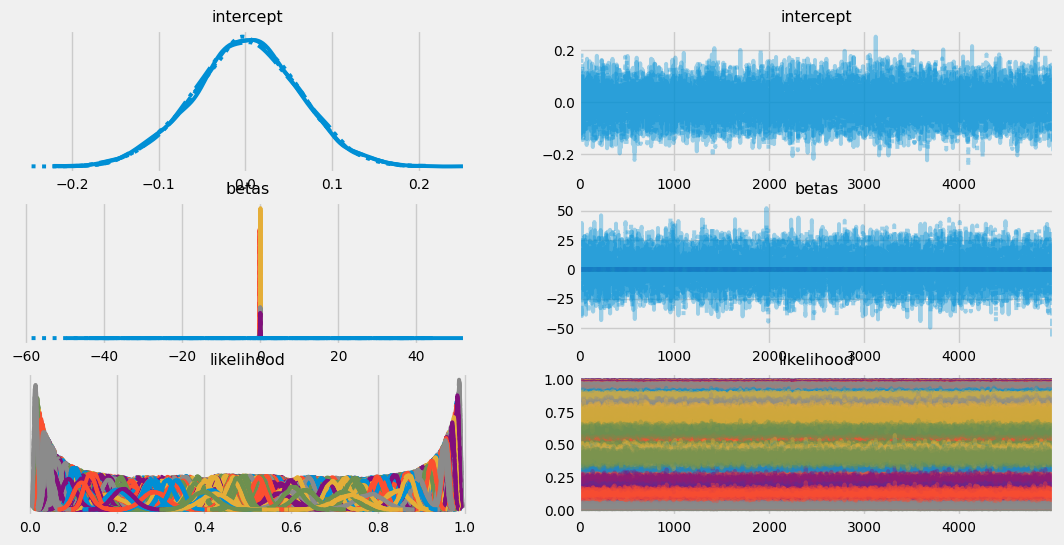

In [ ]:
az.plot_trace(trace);

In [ ]:
az.summary(trace, var_names=["betas"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-0.092,0.147,-0.370,0.182,0.001,0.001,24488.416,16840.950,1.0
betas[1],-0.155,0.011,-0.176,-0.134,0.000,0.000,21537.167,17309.661,1.0
betas[2],0.056,0.010,0.038,0.074,0.000,0.000,20851.096,16173.544,1.0
betas[3],-0.000,0.040,-0.074,0.075,0.000,0.000,27122.990,16656.272,1.0
betas[4],-0.000,0.040,-0.076,0.073,0.000,0.000,24612.100,15141.877,1.0
betas[5],0.000,0.050,-0.091,0.096,0.000,0.000,24976.453,16389.446,1.0
betas[6],0.039,12.891,-24.935,23.721,0.082,0.088,24815.807,16229.971,1.0


In [ ]:
with logistic_model:

    # update values of predictors:
    pm.set_data({"predictors": X_test.values})

    # use the updated values and predict outcomes and probabilities:
    trace = pm.sample_posterior_predictive(
        trace,
        var_names=["likelihood"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True
    )

In [ ]:
model_preds = trace.predictions["likelihood"].mean(("chain", "draw")).values
y_pred = model_preds > 0.5
accuracy_score(y_test, y_pred)

0.7131782945736435

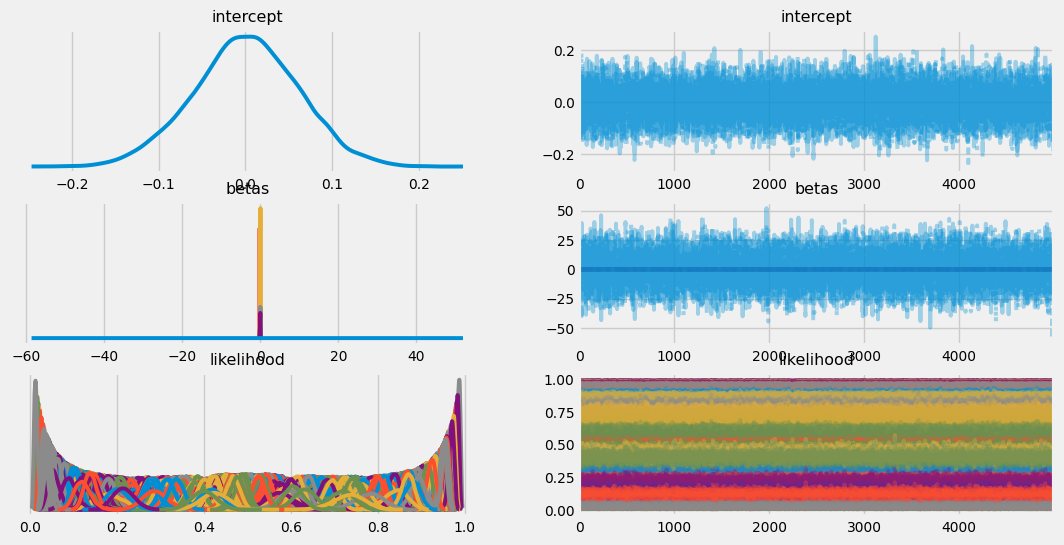

In [ ]:
az.plot_trace(trace, combined=True);

In [ ]:
logistic_model

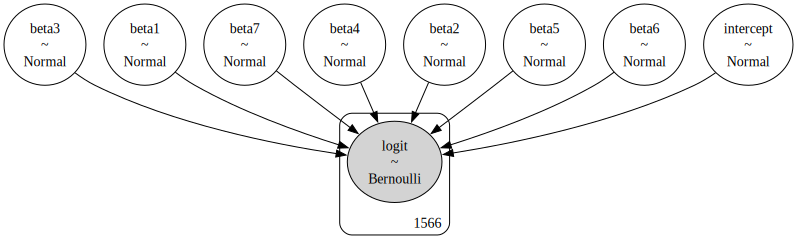

In [ ]:
pm.model_to_graphviz(logistic_model)

In [ ]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
with pm.Model() as logistic_model:


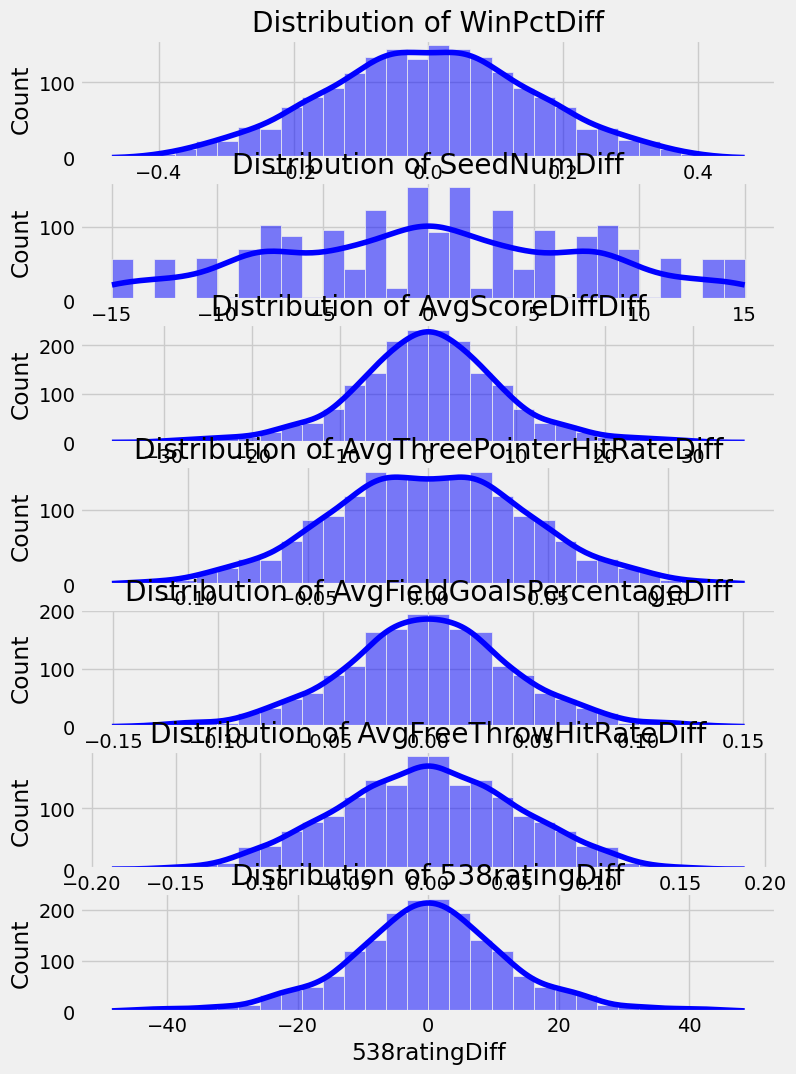

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


y = df_historic_tourney_features[FEATURES]

fig, axes = plt.subplots(len(FEATURES), 1, figsize=(8, 12))
for i, feature in enumerate(FEATURES):
    sns.histplot(df_historic_tourney_features[feature], bins=30, ax=axes[i], kde=True, color='blue')
    axes[i].set_title(f'Distribution of {feature}')

In [ ]:
# Test and simulation
TEST_SEASON = 2023
seeds_2024 = pd.read_csv(data_path + "2024_tourney_seeds.csv")

seeds_2024["ChalkSeed"] = (
    seeds_2024["Seed"].str.replace("a", "").str.replace("b", "").str[1:].astype("int")
)

tourney_pairs = (
    seeds_2024.merge(seeds_2024, on=["Tournament"], suffixes=("", "Opp"))
    .assign(Season=TEST_SEASON)
    .query("TeamID != TeamIDOpp")
    .rename(columns={"Tournament": "League"})
)

tourney_pairs = (
    tourney_pairs.merge(
        team_season_agg[
            ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff",
             "AvgScoreDiff", "SeedNum","AvgThreePointerHitRate",
             "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate" ]
        ],
        on=["Season", "League", "TeamID"],
        how="left",
    )
    .merge(
        team_season_agg[
            ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff",
             "AvgScoreDiff", "SeedNum","AvgThreePointerHitRate",
             "AvgFieldGoalsPercentage", "AvgFreeThrowHitRate" ]
        ].rename(
            columns={
                "TeamID": "TeamIDOpp",
                "WinPercentage": "OppWinPercentage",
                "MedianScoreDiff": "OppMedianScoreDiff",
                "AvgScoreDiff": "AvgScoreDiffOpp",
                "SeedNum": "OppSeedNum",
                "AvgThreePointerHitRate": "AvgThreePointerHitRateOpp",
                "AvgFieldGoalsPercentage": "AvgFieldGoalsPercentageOpp",
                "AvgFreeThrowHitRate": "AvgFreeThrowHitRateOpp"
            }
        ),
        on=["Season", "League", "TeamIDOpp"],
    )
    .reset_index(drop=True)
)

tourney_pairs["OppChalkSeed"] = (
    tourney_pairs["SeedOpp"]
    .str.replace("a", "")
    .str.replace("b", "")
    .str[1:]
    .astype("int")
)


tourney_pairs = tourney_pairs.merge(
    fivethiryeight_scores.drop("TeamName", axis=1),
    on=["Season", "League", "TeamID"],
    how="left",
)


tourney_pairs = tourney_pairs.merge(
    fivethiryeight_scores.drop("TeamName", axis=1).rename(
        columns={"TeamID": "TeamIDOpp"}
    ),
    on=["Season", "League", "TeamIDOpp"],
    how="left",
    suffixes=("", "Opp"),
)

# Diff features
tourney_pairs["538ratingDiff"] = (
    tourney_pairs["538rating"] - tourney_pairs["538ratingOpp"]
)

tourney_pairs["BaselinePred"] = (
    tourney_pairs["ChalkSeed"] < tourney_pairs["OppChalkSeed"]
)

tourney_pairs.loc[
    tourney_pairs["ChalkSeed"] == tourney_pairs["OppChalkSeed"],
    "BaselinePred",
] = (
    tourney_pairs["WinPercentage"] > tourney_pairs["OppWinPercentage"]
)

tourney_pairs["WinPctDiff"] = (
    tourney_pairs["WinPercentage"] - tourney_pairs["OppWinPercentage"]
)

tourney_pairs["ChalkSeedDiff"] = (
    tourney_pairs["ChalkSeed"] - tourney_pairs["OppChalkSeed"]
)

tourney_pairs["MedianScoreDiffDiff"] = (
    tourney_pairs["MedianScoreDiff"] - tourney_pairs["OppMedianScoreDiff"]
)



tourney_pairs["AvgThreePointerHitRateDiff"] = (
    tourney_pairs["AvgThreePointerHitRate"]
    - tourney_pairs["AvgThreePointerHitRateOpp"]
)


tourney_pairs["SeedNumDiff"] = (
    tourney_pairs["SeedNum"]
    - tourney_pairs["OppSeedNum"]
)


tourney_pairs["AvgFieldGoalsPercentageDiff"] = (
    tourney_pairs["AvgFieldGoalsPercentage"]
    - tourney_pairs["AvgFieldGoalsPercentageOpp"]
)

tourney_pairs["AvgScoreDiffDiff"] = (
    tourney_pairs["AvgScoreDiff"]
    - tourney_pairs["AvgScoreDiffOpp"]
)

tourney_pairs["AvgFreeThrowHitRateDiff"] = (
    tourney_pairs["AvgFreeThrowHitRate"]
    - tourney_pairs["AvgFreeThrowHitRateOpp"]
)


# Replace NaN values with a default value, such as 0
tourney_pairs.fillna(0, inplace=True)



for i, model in enumerate(models):
    tourney_pairs[f"pred_model{i}"] = model.predict(tourney_pairs[FEATURES])


tourney_pairs["Pred"] = tourney_pairs[
    [f for f in tourney_pairs.columns if "model" in f]
].mean(axis=1)

tourney_pairs["ID"] = (
    tourney_pairs["Season"].astype("str")
    + "_"
    + tourney_pairs["TeamID"].astype("str")
    + "_"
    + tourney_pairs["TeamIDOpp"].astype("str")
)

preds = tourney_pairs.copy()


# Simulate brackets
from tqdm import tqdm

# Load and filter data
round_slots = pd.read_csv(data_path + "MNCAATourneySlots.csv"
)
round_slots = round_slots[round_slots["Season"] == 2023]
round_slots = round_slots[
    round_slots["Slot"].str.contains("R")
]  # Filter out First Four

seeds = pd.read_csv(
    data_path + "2024_tourney_seeds.csv"
)
seeds_m = seeds[seeds["Tournament"] == "M"]
seeds_w = seeds[seeds["Tournament"] == "W"]

preds["ID"] = preds["ID"].str.split("_")


def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index("Seed")["TeamID"].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}

    for teams, proba in zip(preds["ID"], preds["Pred"]):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, sim=True):
    """
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    """
    winners = []
    slots = []

    for slot, strong, weak in zip(
        round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed
    ):
        team_1, team_2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team_1)][str(team_2)]

        if sim:
            # Randomly determine the winner based on the probability
            winner = np.random.choice([team_1, team_2], p=[proba, 1 - proba])
        else:
            # Determine the winner based on the higher probability
            winner = [team_1, team_2][np.argmax([proba, 1 - proba])]

        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    """
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    """
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets + 1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, sim)

        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({"Bracket": bracket, "Slot": slots, "Team": results})

    return result_df


n_brackets = 1
result_m = run_simulation(
    brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=False
)
result_m["Tournament"] = "M"
result_w = run_simulation(
    brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=False
)
result_w["Tournament"] = "W"
submission = pd.concat([result_m, result_w])
submission = submission.reset_index(drop=True)
submission.index.names = ["RowId"]
submission = submission.reset_index()

ss = pd.read_csv(data_path + "sample_submission.csv")
submission[ss.columns] = submission[ss.columns]
submission[ss.columns].to_csv("submission.csv", index=False)



submission_with_names = submission.rename(columns={"Team": "Seed"}).merge(
    seeds, on=["Seed", "Tournament"], how="left"
)

teams = pd.concat(
    [
        pd.read_csv(data_path + "MTeams.csv").assign(Tournament="M"),
        pd.read_csv(data_path + "WTeams.csv").assign(Tournament="W"),
    ]
)

submission_with_names = submission_with_names.merge(
    teams[["Tournament", "TeamID", "TeamName"]], how="left"
)

submission_with_names